# Phylogenetic distance vs cell size and other genome properties

### This notebook will assess the idea of phylogenetic signal (closely related species tend to have similar values for a given trait more than expected by chance) by looking at the raw data.

In [1]:
# Imports
import numpy as np
import pandas as pd
import os
from skbio import TreeNode, DistanceMatrix
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import spearmanr, pearsonr
from matplotlib import colors as colorsm

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [3]:
from scipy.optimize import curve_fit
from scipy.stats import norm, kstest, kruskal, levene, t, linregress, gaussian_kde

In [4]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 15,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

Load data

In [5]:
df = pd.read_table('place/fine_all.tsv', index_col = 0)
df.shape

(5380, 28)

In [6]:
df['vsratio'] = df['volume_gmean'] / df['surface_gmean']
df['log_vsratio'] = np.log10(df['vsratio'])

In [7]:
df['svratio'] = df['surface_gmean'] / df['volume_gmean']
df['log_svratio'] = np.log10(df['svratio'])

In [8]:
df['log_volume'] = np.log10(df['volume_gmean'])
df['log_surface'] = np.log10(df['surface_gmean'])

In [9]:
df['equivalent_spherical'] = np.cbrt((6 * df['volume_gmean']) / np.pi)
df['log_equivalent_spherical'] = np.log10(df['equivalent_spherical'])

Load tree

In [10]:
tree = TreeNode.read('place/fine_all.nwk')
tree.count(tips = True)

5380

Calculate tip-to-tip distances

In [11]:
dm = tree.tip_tip_distances()
dm.shape

(5380, 5380)

The difference in distance for every pair is calculated as follows:

1. $\frac{\lvert a - b \rvert}{\text{max} - \text{min}}$

2. $\frac{(a - b)^2}{(\text{max} - \text{min})^2}$

* Metric 1 produces values higher than 1, which cannot are not defined by arcsin thereby producing NaN.

Get distances between every pair of tip

In [12]:
df = df.loc[list(dm.ids)]

In [13]:
idx = df.index.tolist()

In [14]:
metrics = ['log_vsratio', 'log_svratio', 'log_volume', 'log_surface', 'log_equivalent_spherical']

In [15]:
%%time
tmp = {}
tmp['pd_dist'] = dm.condensed_form()
for metric in metrics:
    max_size = np.max(df[metric])
    min_size = np.min(df[metric])
    s = df[metric].values
    dm1 = DistanceMatrix.from_iterable(s, lambda a, b: np.abs(a - b) / (max_size - min_size), keys = idx, validate = False).condensed_form()
    dm2 = DistanceMatrix.from_iterable(s, lambda a, b: (a - b) ** 2 / (max_size - min_size) ** 2, keys = idx, validate = False).condensed_form()
        
    # Add to tmp
    tmp[f'diff_{metric}_n1'] = dm1
    tmp[f'diff_{metric}_n2'] = dm2

CPU times: user 2min 53s, sys: 1.12 s, total: 2min 54s
Wall time: 2min 55s


In [16]:
%%time
dfm = pd.DataFrame(tmp)
dfm.shape

CPU times: user 207 ms, sys: 338 ms, total: 546 ms
Wall time: 562 ms


(14469510, 11)

In [17]:
dfm.head()

,pd_dist,diff_log_vsratio_n1,diff_log_vsratio_n2,diff_log_svratio_n1,diff_log_svratio_n2,diff_log_volume_n1,diff_log_volume_n2,diff_log_surface_n1,diff_log_surface_n2,diff_log_equivalent_spherical_n1,diff_log_equivalent_spherical_n2
0,0.084955,0.208098,0.043305,0.208098,0.043305,0.202950,0.041189,0.183873,0.033809,0.202950,0.041189
1,0.275433,0.223599,0.049997,0.223599,0.049997,0.218067,0.047553,0.197569,0.039033,0.218067,0.047553
2,0.275433,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.539253,0.208098,0.043305,0.208098,0.043305,0.202950,0.041189,0.183873,0.033809,0.202950,0.041189
4,0.674639,0.165702,0.027457,0.165702,0.027457,0.260095,0.067650,0.280265,0.078548,0.260095,0.067650


Arcsine transformation

In [18]:
for metric in metrics:
    dfm[f'diff_{metric}_n1_arcsin'] = np.arcsin(np.sqrt(dfm[f'diff_{metric}_n1']))
    dfm[f'diff_{metric}_n2_arcsin'] = np.arcsin(np.sqrt(dfm[f'diff_{metric}_n2']))

In [19]:
colors = ['#c1121f', '#264653', '#2a9d8f', '#e9c46a', '#f4a261']

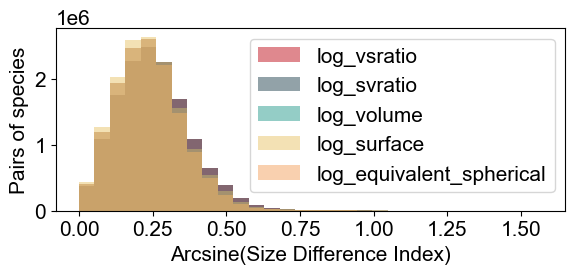

In [20]:
plt.figure(figsize = (6, 3))

for i, metric in enumerate(metrics):
    plt.hist(dfm[f'diff_{metric}_n1_arcsin'], bins = 30, alpha = 0.5, label = metric, color = colors[i])

plt.legend()
plt.xlabel('Arcsine(Size Difference Index)')
plt.ylabel('Pairs of species')
plt.show()

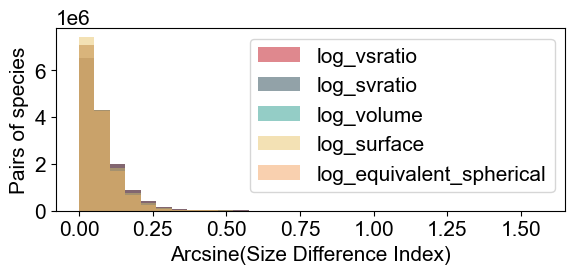

In [21]:
plt.figure(figsize = (6, 3))

for i, metric in enumerate(metrics):
    plt.hist(dfm[f'diff_{metric}_n2_arcsin'], bins = 30, alpha = 0.5, label = metric, color = colors[i])

plt.legend()
plt.xlabel('Arcsine(Size Difference Index)')
plt.ylabel('Pairs of species')
plt.show()

Multiple fit

In [22]:
def linear_func(x, a, b):
    return a * x + b

def polynomial_func(x, *coefficients):
    return np.polyval(coefficients, x)

def exponential_func(x, a, b):
    return a * np.exp(b * x)

def piecewise_linear_func(x, x0, y0, k1, k2):
    # Returns the 
    return np.piecewise(x, [x < x0, x >= x0], [lambda x: k1 * x + y0 - k1 * x0, lambda x: k2 * x + y0 - k2 * x0])

def squared(x, a):
    return a * x ** 2

In [23]:
def curve_fitting(func, x, y):
    # Fit data to function
    if func == polynomial_func:
        coeffs, cov = curve_fit(func, x, y, [1, 0, 0])
    elif func == piecewise_linear_func:
        # Start paramaters
        coeffs, cov = curve_fit(func, x, y, [np.mean(x), np.mean(y), 1, 1])
    else:
        coeffs, cov = curve_fit(func, x, y)

    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = func(x, *coeffs)
    # Calculate standard errors
    std_err = np.sqrt(np.diag(cov))

    # Calculate degrees of freedom
    df = len(x) - len(coeffs)

    # Compute t-statistics
    t_stats = coeffs / std_err

    # Compute p-values, two-sided t-test
    p_values = (1 - t.cdf(np.abs(t_stats), df)) * 2 

    # Calculate confidence interval --needs adjustment
    # y_lower = func(x_fit, (*coeffs - std))
    # y_upper = func(x_fit, (*coeffs + std))
    
    return x_fit, y_fit, coeffs, p_values

Analizing the goodness of fit with $R^2$

In [24]:
labels = ['Linear', 'Polynomial', 'Exponential', 'Piecewise linear', 'Squared']
styles = ['solid', 'dotted', 'dashed', 'dashdot']

In [26]:
for metric in metrics:
    print(f'Metric: {metric}')
    x, y = dfm['pd_dist'].to_numpy(), dfm[f'diff_{metric}_n1_arcsin'].to_numpy()
    for i, func in enumerate([linear_func, polynomial_func, exponential_func, piecewise_linear_func, squared]):
        print(f'\tFunction: {labels[i]}')
        x_fit, y_fit, coeffs, p_values = curve_fitting(func, x, y)
        # Residuals
        residuals = (y - y_fit) ** 2
        mse = np.sum(residuals) / len(x)
        # DO residuals follow a normal distribution?
        parameters = norm.fit(np.log10(residuals))
        gft = kstest(np.log10(residuals), 'norm', parameters)
        print(f'\t\tKolmogorov-Smirnov test for normality of residuals (P-value): {gft[1]:.2f}')
        # Calculate R^2
        r2 = 1 - np.sum(residuals) / np.sum((y - np.mean(y)) ** 2)
        print(f'\t\tMSE: {mse:.2f}, r2: {r2:.4f}')
        print(f'\t\tCoefficients: {coeffs}')
        print(f'\t\tP-values: {p_values}')

Metric: log_vsratio
	Function: Linear
		Kolmogorov-Smirnov test for normality of residuals (P-value): 0.00
		MSE: 0.02, r2: 0.0196
		Coefficients: [0.04805084 0.18443477]
		P-values: [0. 0.]
	Function: Polynomial
		Kolmogorov-Smirnov test for normality of residuals (P-value): 0.00
		MSE: 0.02, r2: 0.0238
		Coefficients: [ 0.03983069 -0.06333102  0.25640126]
		P-values: [0. 0. 0.]
	Function: Exponential
		Kolmogorov-Smirnov test for normality of residuals (P-value): 0.00
		MSE: 0.02, r2: 0.0206
		Coefficients: [0.18933111 0.20049014]
		P-values: [0. 0.]
	Function: Piecewise linear
		Kolmogorov-Smirnov test for normality of residuals (P-value): 0.00
		MSE: 0.02, r2: 0.0352
		Coefficients: [1.87536082 0.25943246 0.02184138 0.26486287]
		P-values: [0. 0. 0. 0.]
	Function: Squared
		Kolmogorov-Smirnov test for normality of residuals (P-value): 0.00
		MSE: 0.02, r2: -0.4312
		Coefficients: [0.09237473]
		P-values: [0.]
Metric: log_svratio
	Function: Linear
		Kolmogorov-Smirnov test for norma

In [27]:
for metric in metrics:
    print(f'Metric: {metric}')
    x, y = dfm['pd_dist'].to_numpy(), dfm[f'diff_{metric}_n2_arcsin'].to_numpy()
    for i, func in enumerate([linear_func, polynomial_func, exponential_func, piecewise_linear_func, squared]):
        print(f'\tFunction: {labels[i]}')
        x_fit, y_fit, coeffs, p_values = curve_fitting(func, x, y)
        # Residuals
        residuals = (y - y_fit) ** 2
        mse = np.sum(residuals) / len(x)
        # DO residuals follow a normal distribution?
        parameters = norm.fit(np.log10(residuals))
        gft = kstest(np.log10(residuals), 'norm', parameters)
        print(f'\t\tKolmogorov-Smirnov test for normality of residuals (P-value): {gft[1]:.2f}')
        # Calculate R^2
        r2 = 1 - np.sum(residuals) / np.sum((y - np.mean(y)) ** 2)
        print(f'\t\tMSE: {mse:.2f}, r2: {r2:.4f}')
        print(f'\t\tCoefficients: {coeffs}')
        print(f'\t\tP-values: {p_values}')

Metric: log_vsratio
	Function: Linear
		Kolmogorov-Smirnov test for normality of residuals (P-value): 0.00
		MSE: 0.01, r2: 0.0186
		Coefficients: [0.02738096 0.03679218]
		P-values: [0. 0.]
	Function: Polynomial
		Kolmogorov-Smirnov test for normality of residuals (P-value): 0.00
		MSE: 0.01, r2: 0.0221
		Coefficients: [ 0.02158918 -0.03299066  0.07579973]
		P-values: [0. 0. 0.]
	Function: Exponential
		Kolmogorov-Smirnov test for normality of residuals (P-value): 0.00
		MSE: 0.01, r2: 0.0203
		Coefficients: [0.04237542 0.397781  ]
		P-values: [0. 0.]
	Function: Piecewise linear
		Kolmogorov-Smirnov test for normality of residuals (P-value): 0.00
		MSE: 0.01, r2: 0.0335
		Coefficients: [1.87445479 0.07946664 0.01236319 0.15100012]
		P-values: [0. 0. 0. 0.]
	Function: Squared
		Kolmogorov-Smirnov test for normality of residuals (P-value): 0.00
		MSE: 0.01, r2: -0.0617
		Coefficients: [0.02884004]
		P-values: [0.]
Metric: log_svratio
	Function: Linear
		Kolmogorov-Smirnov test for norma

In [31]:
# plt.figure(figsize = (12, 5))

# # Fit to all the data pairs
# for i, metric in enumerate(metrics):
#     x, y = dfm['pd_dist'].to_numpy(), dfm[f'diff_{metric}_n1_arcsin'].to_numpy()
    
#     # # For scatter plot, randomly sample n pairs of data points
#     # plt.scatter(dfm_sample['pd_dist'], dfm_sample['diff_log_svratio_n2_arcsin'], color = '#6c757d', 
#     #             alpha = 0.3, edgecolor = 'none', s = 5, label = 'Pairs of species')
    
#     # Fit--only the best fit according to R^2
#     x_fit, y_fit, coeffs, p_values = curve_fitting(piecewise_linear_func, x, y)
#     plt.plot(np.sort(x), np.sort(y_fit), color = colors[i], label = metric, alpha = 0.7)
    
#     # Add parameters
#     plt.axvline(x = coeffs[0], color = colors[i], linestyle = 'dashed', alpha = 1.0)
    
#     # End of first piece
#     plt.text(coeffs[0] * 0.95, coeffs[1] * 1.5, f'x = {coeffs[0]:.2f}\np = {p_values[0]}', color = 'k',
#             ha = 'center', va = 'bottom', rotation = 90)
#     # Slope 1
#     plt.text(coeffs[0] * 0.5, coeffs[1] * 1.5, f'x = {coeffs[2]:.2f}\np = {p_values[2]}', color = 'k',
#             ha = 'center', va = 'bottom', rotation = 90)
#     # Slope 2
#     plt.text(coeffs[0] * 1.5, coeffs[1] * 2.0, f'x = {coeffs[3]:.2f}\np = {p_values[3]}', color = 'k',
#             ha = 'center', va = 'bottom', rotation = 90)
    
# plt.xlabel('Patristic distance\n(substitutions per site)')
# plt.ylabel('Arcsine(Size Difference Index)')
# plt.legend()
# plt.xticks(np.arange(0, 3, 0.2))
# plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
# plt.ylim(-0.02, 1.05)
# plt.xlim(-0.1, 2.9)

# plt.show()

In [25]:
n = 50000
dfm_sample = dfm.sample(n, random_state = 42).copy()

In [26]:
x_sample, y_sample = dfm_sample['pd_dist'].to_numpy(), dfm_sample[f'diff_log_svratio_n1_arcsin'].to_numpy()

In [27]:
def kde(x_sample, y_sample):
    '''
    Perform KDE
    '''
    # KDE
    kernel = gaussian_kde(np.vstack([x_sample, y_sample]))
    # Bandwidth
    bw = np.sqrt(np.sqrt(np.prod(np.diag(kernel.covariance))))
    # Plot range (200 x 200 grid, 3x bandwidth beyond extreme)
    cut = 3
    gridsize = 200
    xmin = x_sample.min() - bw * cut
    xmax = x_sample.max() + bw * cut
    ymin = y_sample.min() - bw * cut
    ymax = y_sample.max() + bw * cut
    xran = np.linspace(xmin, xmax, gridsize)
    yran = np.linspace(ymin, ymax, gridsize)
    X, Y = np.meshgrid(xran, yran)
    xygrid = np.vstack([X.ravel(), Y.ravel()])
    # Probability density across the grid
    probs = kernel(xygrid)
    Z = probs.reshape(gridsize, gridsize)
    # Contour above probability mass 0.1%.
    thresh = 0.001
    probs_sorted = np.sort(probs.ravel())[::-1]
    unit_area = (xmax - xmin) * (ymax - ymin) / (gridsize - 1) ** 2
    idx = np.flatnonzero(np.cumsum(probs_sorted) >= (1 - thresh) / unit_area)[0]
    prob_th = probs_sorted[idx]
    # Conver to species density
    Z *= (n / 1000)
    prob_th *= (n / 1000)
    levels = np.linspace(prob_th, Z.max(), 8)

    return X, Y, Z, levels

In [28]:
X, Y, Z, levels = kde(x_sample, y_sample)

In [29]:
# plt.figure(figsize = (12, 5))
# # Pairs of species
# plt.contourf(X, Y, Z, cmap = 'binary', levels = levels)
# plt.colorbar(label = 'Pairs of species density')
# plt.scatter(x_sample, y_sample, c = 'k', s = 5, alpha = 0.1)

# # Linear fit
# x, y = dfm['pd_dist'].to_numpy(), dfm[f'diff_log_vsratio_n1_arcsin'].to_numpy()
# x_fit, y_fit, coeffs, p_values = curve_fitting(piecewise_linear_func, x, y)
# plt.plot(np.sort(x), np.sort(y_fit), color = '#c1121f', label = metric, alpha = 0.7)

# # Add parameters
# plt.axvline(x = coeffs[0], color = 'grey', linestyle = 'dashed', alpha = 1.0)

# # End of first piece
# plt.text(coeffs[0] * 0.95, coeffs[1] * 1.5, f'x = {coeffs[0]:.2f}\np = {p_values[0]}', color = 'k',
#         ha = 'center', va = 'bottom', rotation = 90)
# # Slope 1
# plt.text(coeffs[0] * 0.5, coeffs[1] * 1.5, f'x = {coeffs[2]:.2f}\np = {p_values[2]}', color = 'k',
#         ha = 'center', va = 'bottom', rotation = 90)
# # Slope 2
# plt.text(coeffs[0] * 1.5, coeffs[1] * 2.0, f'x = {coeffs[3]:.2f}\np = {p_values[3]}', color = 'k',
#         ha = 'center', va = 'bottom', rotation = 90)

# plt.xlabel('Patristic distance\n(substitutions per site)')
# plt.ylabel('Arcsine(Size Difference Index)')
# plt.show()

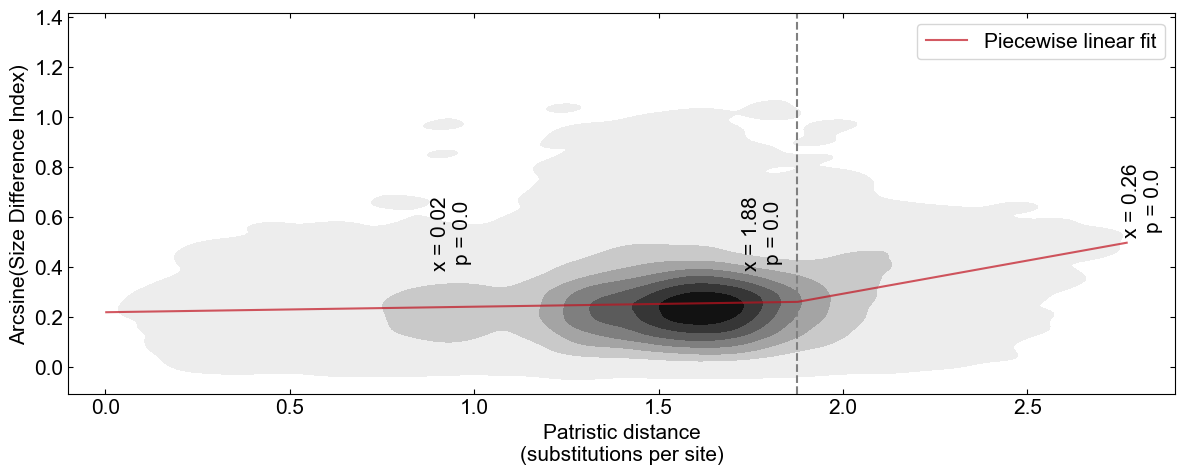

In [33]:
plt.figure(figsize = (12.1, 5))
# Pairs of species
plt.contourf(X, Y, Z, cmap = 'binary', levels = levels)
# plt.colorbar(label = 'Pairs of species density')
# plt.scatter(x_sample, y_sample, c = 'k', s = 5, alpha = 0.1)

# Linear fit
x, y = dfm['pd_dist'].to_numpy(), dfm[f'diff_log_vsratio_n1_arcsin'].to_numpy()
x_fit, y_fit, coeffs, p_values = curve_fitting(piecewise_linear_func, x, y)
plt.plot(np.sort(x), np.sort(y_fit), color = '#c1121f', label = f'Piecewise linear fit', alpha = 0.7, zorder = 3)

# Add parameters
plt.axvline(x = coeffs[0], color = 'grey', linestyle = 'dashed', alpha = 1.0)

# End of first piece
plt.text(coeffs[0] * 0.95, coeffs[1] * 1.5, f'x = {coeffs[0]:.2f}\np = {p_values[0]}', color = 'k',
        ha = 'center', va = 'bottom', rotation = 90)
# Slope 1
plt.text(coeffs[0] * 0.5, coeffs[1] * 1.5, f'x = {coeffs[2]:.2f}\np = {p_values[2]}', color = 'k',
        ha = 'center', va = 'bottom', rotation = 90)
# Slope 2
plt.text(coeffs[0] * 1.5, coeffs[1] * 2.0, f'x = {coeffs[3]:.2f}\np = {p_values[3]}', color = 'k',
        ha = 'center', va = 'bottom', rotation = 90)

plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.xlim(-0.1, 2.9)
plt.legend()
plt.xlabel('Patristic distance\n(substitutions per site)')
plt.ylabel('Arcsine(Size Difference Index)')
plt.savefig('figures/pd_dist_svratio_all.svg')
plt.show()

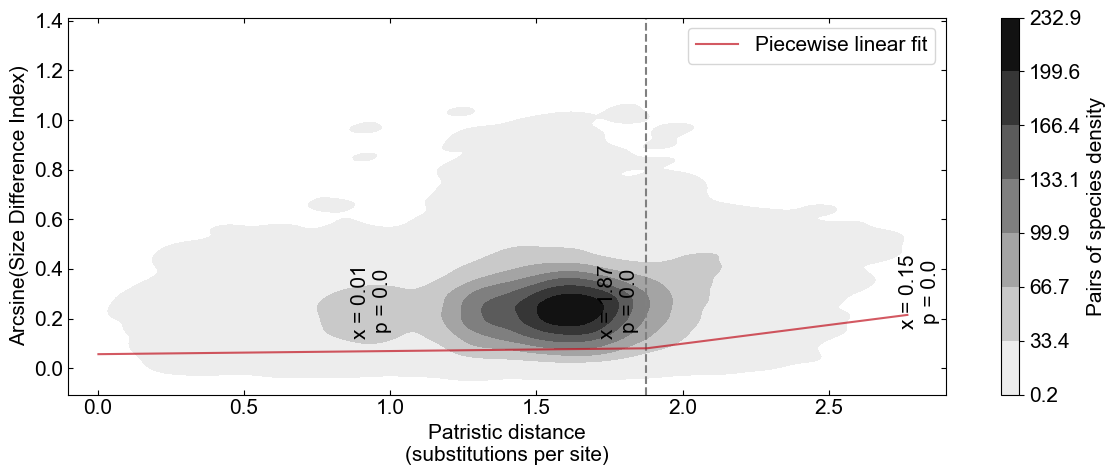

In [39]:
plt.figure(figsize = (12, 5))
# Pairs of species
plt.contourf(X, Y, Z, cmap = 'binary', levels = levels)
plt.colorbar(label = 'Pairs of species density')
# plt.scatter(x_sample, y_sample, c = 'k', s = 5, alpha = 0.1)

# Linear fit
x, y = dfm['pd_dist'].to_numpy(), dfm[f'diff_log_vsratio_n2_arcsin'].to_numpy()
x_fit, y_fit, coeffs, p_values = curve_fitting(piecewise_linear_func, x, y)
plt.plot(np.sort(x), np.sort(y_fit), color = '#c1121f', label = 'Piecewise linear fit', alpha = 0.7, zorder = 3)

# Add parameters
plt.axvline(x = coeffs[0], color = 'grey', linestyle = 'dashed', alpha = 1.0)

# End of first piece
plt.text(coeffs[0] * 0.95, coeffs[1] * 1.5, f'x = {coeffs[0]:.2f}\np = {p_values[0]}', color = 'k',
        ha = 'center', va = 'bottom', rotation = 90)
# Slope 1
plt.text(coeffs[0] * 0.5, coeffs[1] * 1.5, f'x = {coeffs[2]:.2f}\np = {p_values[2]}', color = 'k',
        ha = 'center', va = 'bottom', rotation = 90)
# Slope 2
plt.text(coeffs[0] * 1.5, coeffs[1] * 2.0, f'x = {coeffs[3]:.2f}\np = {p_values[3]}', color = 'k',
        ha = 'center', va = 'bottom', rotation = 90)

plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.xlim(-0.1, 2.9)
plt.legend()
plt.xlabel('Patristic distance\n(substitutions per site)')
plt.ylabel('Arcsine(Size Difference Index)')
plt.show()